In [5]:
import gc
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
df = df.append(test).reset_index()

In [16]:
int_cols  = ["MSSubClass","MSZoning", "Street", "Alley", "LotShape","LandContour" ,"Utilities","LotConfig","LandSlope", "Neighborhood","Condition1","Condition2", "BldgType", "HouseStyle","OverallQual","OverallCond","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType","ExterQual","ExterCond","Foundation","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1", "BsmtFinType2","Heating","HeatingQC","CentralAir","Electrical","KitchenQual","Functional","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond","PavedDrive","PoolQC","Fence","MiscFeature","SaleType","SaleCondition"]
for col in int_cols:
    df[col] = df[col].astype("object")

In [333]:
## OUTLİER
df =df[df['SalePrice'] < 300000.0]

In [17]:
### NEW FEATURES
df["Floorcross_tersr"]=(df["2ndFlrSF"] + df["1stFlrSF"]) / df["1stFlrSF"]
df["Total_Floor"]=df["1stFlrSF"] + df["2ndFlrSF"]
df["_Floor_cross"] =df["1stFlrSF"] * (df["1stFlrSF"] + df["2ndFlrSF"])
df["Zemin_Alan_Kullanımı"]=(df["GrLivArea"] + df["1stFlrSF"]*df["1stFlrSF"])/df["1stFlrSF"]
df["Alana_düşen_Mutfak"]=df["KitchenAbvGr"] / df["1stFlrSF"]
df["bodrum_banyo_per"]=(df["BsmtFullBath"] + (df["TotalBsmtSF"])/df["TotalBsmtSF"])
df["GrLivArea"] = np.log10(df["GrLivArea"])
df["mean_1stFlrSF_GrLivArea"] = df[['1stFlrSF', 'GrLivArea']].mean(axis=1)
df['std_1stFlrSF_GrLivArea'] = df[['1stFlrSF', 'GrLivArea']].std(axis=1)
df['BsmtQual'].fillna('No_Basement', inplace=True)
df['BsmtCond'].fillna('No_Basement', inplace=True)
df['BsmtExposure'].fillna('No_Basement', inplace=True)
df['BsmtFinType1'].fillna('No_Basement', inplace=True)
df['BsmtFinType2'].fillna('No_Basement', inplace=True)
df['FireplaceQu'].fillna('No_Fireplace', inplace=True)
df['GarageType'].fillna('No_Garage', inplace=True)
df['GarageFinish'].fillna('No_Garage', inplace=True)
df['GarageQual'].fillna('No_Garage', inplace=True)
df['GarageCond'].fillna('No_Garage', inplace=True)
df['PoolQC'].fillna('No_Garage', inplace=True)
df["Lot_divide"] = (df["LotArea"] / df["LotFrontage"]) 
df["MSSubClass"] = df["MSSubClass"].astype("O") 
df["MSZoning"] = df["MSZoning"].astype("O")
### NEW VARIABLES
df["Functional"] = np.where(df.Functional.isin(["Sev", "Maj2", "Maj1","Mod"]), "smmm", df["Functional"])
df["BldgType"] = np.where(df.BldgType.isin(["2fmCon", "Twnhs"]), "2T", df["BldgType"])
df["HouseStyle"] = np.where(df.HouseStyle.isin(["2.5Fin", "1.5Unf" ,"2.5Unf","SFoyer"]), "121", df["HouseStyle"])
df["ExterQual"] = np.where(df.ExterQual.isin(["Fa", "Ex"]), "FaEx", df["ExterQual"])
df["Foundation"] = np.where(df.Foundation.isin(["Wood", "Stone","Slab","BrkTil"]), "2T", df["Foundation"])
df["MSZoning"] = np.where(df.MSZoning.isin(["C (all)", "RH"]), "CRH", df["MSZoning"])
df["Fireplaces"] = np.where(df.Fireplaces.isin(["4", "3"]), "43", df["Fireplaces"])
df["GarageCars"] = np.where(df.GarageCars.isin(["4.000", "5.000"]), "45", df["GarageCars"])
df["Condition1"] = np.where(df.Condition1.isin(["RRNn", "RRNe","RRAn"]), "RRR", df["Condition1"])
df["Exterior2nd"] = np.where(df.Exterior2nd.isin(["AsbShng", "AsphShn"]), "AA", df["Exterior2nd"])
df["Exterior2nd"] = np.where(df.Exterior2nd.isin(["Brk Cmn", "BrkFace"]), "BB", df["Exterior2nd"])
df["Exterior2nd"] = np.where(df.Exterior2nd.isin(["Other", "Stone","CBlock"]), "OSC", df["Exterior2nd"])
del test
gc.collect()


8

In [310]:
####  DROPPING COLUMNS
df.drop("PoolArea", axis=1, inplace=True)
drop_list = ["BsmtFinSF2","WoodDeckSF","ScreenPorch", "BsmtExposure", "CentralAir","Electrical", "PavedDrive","LandContour", "BldgType", "Heating","Street","Utilities","Condition2", "RoofMatl", "index", "MiscFeature","Fence","PoolQC","GarageCond","Alley", "MiscVal", "3SsnPorch","LowQualFinSF"]
df.drop(drop_list, axis=1, inplace=True)

In [18]:
aggregations_MS = {"LotFrontage":["sum","mean"],
                    "LotArea": ["min", "mean","sum","max"],
                    "LandSlope": ["nunique"],
                     "GrLivArea":["std","var"]}
MSZoning = df.groupby('MSZoning').agg(aggregations_MS)

MSZoning.columns = pd.Index(['MSZoning' + e[0] + "_" + e[1].upper() for e in MSZoning.columns.tolist()])


df.drop(["LotFrontage","LotArea", "LandSlope" ],axis=1, inplace=True)
    
MSZoning.reset_index()



,MSZoning,MSZoningLotFrontage_SUM,MSZoningLotFrontage_MEAN,MSZoningLotArea_MIN,MSZoningLotArea_MEAN,MSZoningLotArea_SUM,MSZoningLotArea_MAX,MSZoningLandSlope_NUNIQUE,MSZoningGrLivArea_STD,MSZoningGrLivArea_VAR
0,CRH,2784.000,60.522,3300,7905.608,403186,18000,2,0.171,0.029
1,FV,7084.000,59.529,2117,6549.360,910361,13162,1,0.087,0.008
2,RL,136182.000,74.052,1700,11169.472,25298854,215245,3,0.140,0.020
3,RM,22257.000,52.246,1300,6400.239,2944110,33120,2,0.140,0.020


In [19]:
df = df.join(MSZoning, how='left', on='MSZoning') 

In [61]:
def outlier_thresholds(dataframe, variable, low_quantile=0.25, up_quantile=0.75):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in num_cols:
    if col != "SalePrice":
        print(col, check_outlier(df, col))




KeyError: 'log_YearBuilt'

In [155]:
# Aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)


In [20]:
df["Home_Age"] = df["YrSold"]- df["YearBuilt"] 
df["Restore_age"] = df["YrSold"] - df["YearRemodAdd"]

In [21]:
aggregations_BC = {"GarageArea":["sum","mean"],
                   "OpenPorchSF":["min", "mean","sum","max"],
                     "TotRmsAbvGrd": ["mean", "size"],
                    "TotalBsmtSF": ["mean","sum","max"],
                     "GrLivArea": ["min", "max", "size"],
                       "1stFlrSF": ["var","mean","max", "std"],
                       "2ndFlrSF" : ["var", "std", "mean","min"],
                       "EnclosedPorch": ["min", "max"],
                        "Home_Age" :["mean","max","sum"],
                      "Restore_age":["mean","var","min","max","sum"],
                         "Total_Floor":["mean","sum"],
                         "Alana_düşen_Mutfak" : ["mean", "sum"]
                                        }

MSSubClass = df.groupby('MSSubClass').agg(aggregations_BC)

MSSubClass.columns = pd.Index(['MSSubClass' + e[0] + "_" + e[1].upper() for e in MSSubClass.columns.tolist()])


MSSubClass.reset_index()

,MSSubClass,MSSubClassGarageArea_SUM,MSSubClassGarageArea_MEAN,MSSubClassOpenPorchSF_MIN,MSSubClassOpenPorchSF_MEAN,MSSubClassOpenPorchSF_SUM,MSSubClassOpenPorchSF_MAX,MSSubClassTotRmsAbvGrd_MEAN,MSSubClassTotRmsAbvGrd_SIZE,MSSubClassTotalBsmtSF_MEAN,MSSubClassTotalBsmtSF_SUM,MSSubClassTotalBsmtSF_MAX,MSSubClassGrLivArea_MIN,MSSubClassGrLivArea_MAX,MSSubClassGrLivArea_SIZE,MSSubClass1stFlrSF_VAR,MSSubClass1stFlrSF_MEAN,MSSubClass1stFlrSF_MAX,MSSubClass1stFlrSF_STD,MSSubClass2ndFlrSF_VAR,MSSubClass2ndFlrSF_STD,MSSubClass2ndFlrSF_MEAN,MSSubClass2ndFlrSF_MIN,MSSubClassEnclosedPorch_MIN,MSSubClassEnclosedPorch_MAX,MSSubClassHome_Age_MEAN,MSSubClassHome_Age_MAX,MSSubClassHome_Age_SUM,MSSubClassRestore_age_MEAN,MSSubClassRestore_age_VAR,MSSubClassRestore_age_MIN,MSSubClassRestore_age_MAX,MSSubClassRestore_age_SUM,MSSubClassTotal_Floor_MEAN,MSSubClassTotal_Floor_SUM,MSSubClassAlana_düşen_Mutfak_MEAN,MSSubClassAlana_düşen_Mutfak_SUM
0,20,546168.000,506.180,0,46.750,50443,484,6.027,1079,1252.864,1350587.000,5095.000,2.524,3.707,1079,164898.780,1352.872,5095,406.077,744.037,27.277,0.830,0,0,584,29.783,71,32136,23.036,424.866,-2,60,24856,1353.703,1460645,0.001,0.865
1,30,39823.000,286.496,0,21.446,2981,523,4.820,139,755.806,105057.000,1580.000,2.641,3.309,139,52567.656,907.158,2039,229.276,846.396,29.093,2.468,0,0,286,81.309,122,11302,40.633,538.625,0,60,5648,909.626,126438,0.001,0.162
2,40,1922.000,320.333,0,15.500,93,65,4.833,6,911.833,5471.000,1332.000,2.937,3.208,6,51366.800,992.000,1332,226.642,29556.667,171.921,154.667,0,0,183,69.833,87,419,27.667,495.067,3,59,166,1146.667,6880,0.001,0.006
3,45,5012.000,278.444,0,8.944,161,112,4.944,18,815.889,14686.000,993.000,2.894,3.097,18,8833.124,892.778,1108,93.985,12522.458,111.904,36.889,0,0,244,73.500,106,1323,42.667,517.765,4,59,768,929.667,16734,0.001,0.020
4,50,100751.000,351.049,0,23.049,6615,547,6.505,287,839.418,240913.000,2033.000,2.826,3.537,287,60663.209,957.617,2129,246.299,46775.566,216.277,511.578,0,0,1012,73.178,135,21002,39.132,507.961,0,60,11231,1469.195,421659,0.001,0.321
5,60,335996.000,584.341,0,79.897,45941,570,7.809,575,1021.537,587384.000,6110.000,3.103,3.751,575,119995.678,1066.330,4692,346.404,52652.697,229.462,929.445,438,0,368,12.833,98,7379,10.492,123.344,-1,59,6033,1995.776,1147571,0.001,0.582
6,70,47870.000,376.929,0,42.922,5494,312,7.227,128,734.141,93970.000,1370.000,2.937,3.504,128,62435.029,917.203,1940,249.870,48232.464,219.619,773.234,322,0,386,89.992,136,11519,30.125,565.102,0,60,3856,1690.438,216376,0.001,0.151
7,75,10278.000,446.870,0,130.043,2991,502,8.522,23,960.652,22095.000,1836.000,3.046,3.565,23,120832.711,1150.435,1836,347.610,120365.522,346.937,1002.609,530,0,552,91.000,128,2093,25.696,437.949,1,59,591,2153.043,49520,0.001,0.024
8,80,55983.000,474.432,0,32.525,3838,253,6.297,118,868.500,102483.000,1952.000,2.956,3.474,118,86528.857,1170.076,2151,294.158,108867.386,329.951,226.712,0,0,294,31.669,58,3737,26.314,255.140,1,54,3105,1396.788,164821,0.001,0.106
9,85,22659.000,472.062,0,18.792,902,144,5.292,48,900.042,43202.000,1420.000,2.885,3.284,48,40777.383,1016.354,1701,201.934,42423.521,205.970,29.729,0,0,252,34.104,86,1637,29.125,169.559,1,59,1398,1046.083,50212,0.001,0.049


In [22]:
df.drop(["EnclosedPorch","2ndFlrSF","1stFlrSF", "GarageArea", "OpenPorchSF", "GrLivArea", "TotRmsAbvGrd", "TotalBsmtSF" ],axis=1, inplace=True)

df = df.join(MSSubClass, how='left', on='MSSubClass')


drop_year=["YearRemodAdd", "YearBuilt", "YrSold", "GarageYrBlt"]
df.drop(drop_year,axis=1,inplace=True)

In [127]:
########## Fuctional

#aggregations_FC = { "GarageCars" : ["min", "max"],
   #                     "GarageArea" : ["mean"],
    #                 "EnclosedPorch": ["mean"],
     #                "1stFlrSF" : ["mean", "min", "std", "max"],
      #               "KitchenAbvGr": ["min", "max"],
       #             "BedroomAbvGr": ["mean", "std", "var"],
        #             "TotRmsAbvGrd": ["mean"]
         #              }
#Functional = df.groupby('Functional').agg(aggregations_FC)
 
#Functional.columns = pd.Index(['Functional' + e[0] + "_" + e[1].upper() for e in Functional.columns.tolist()])

#df.drop(["GarageCars","GarageArea","EnclosedPorch","1stFlrSF","KitchenAbvGr", "BedroomAbvGr","TotRmsAbvGrd"],axis=1, inplace=True)


#df = df.join(Functional, how='left', on="Functional")   



######## MSZoning

aggregations_MS = {"LotFrontage":["sum","mean"],
                    "LotArea": ["min", "mean","sum","max"],
                    "Street":["nunique", "size"],
                     "LandContour": ["nunique"],
                    "LandSlope": ["nunique"],
                      }
MSZoning = df.groupby('MSZoning').agg(aggregations_MS)

MSZoning.columns = pd.Index(['MSZoning' + e[0] + "_" + e[1].upper() for e in MSZoning.columns.tolist()])
 
df.drop(["LotFrontage","MiscVal", "LotArea", "Street", "LandContour", "LandSlope" ],axis=1, inplace=True)
    
df = df.join(MSZoning, how='left', on='MSZoning')   




####### MSSubClass



aggregations_BC = { "WoodDeckSF": ["mean","sum","max"],
                    "OpenPorchSF":["min", "mean","sum","max"],
                    "TotalBsmtSF": ["mean","sum","max"],
                     "GrLivArea": ["min", "max", "size"],
                      "Build" : ["min","max"],
                       "2ndFlrSF" : ["var", "std", "mean","min"]
                       }
MSSubClass = df.groupby('MSSubClass').agg(aggregations_BC)

MSSubClass.columns = pd.Index(['MSSubClass' + e[0] + "_" + e[1].upper() for e in MSSubClass.columns.tolist()])
    
df.drop(["2ndFlrSF","Build", "WoodDeckSF", "OpenPorchSF", "GrLivArea",  "TotalBsmtSF" ],axis=1, inplace=True)

df = df.join(MSSubClass, how='left', on='MSSubClass')   




df.drop("Std_Build", axis=1, inplace=True)

KeyError: "Column(s) ['Build'] do not exist"

In [31]:
def grab_col_names(dataframe, cat_th=100, car_th=20, num_th = 118):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in "SalePrice" and col not in "Id"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols, num_but_cat


cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 122
cat_cols: 104
num_cols: 15
cat_but_car: 1
num_but_cat: 58


In [26]:
for col in num_cols:
    df[col] = np.log10(df[col] + 1)

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
df.drop("index",axis=1,inplace=True)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_list = ["LotShape","LandContour","Utilities","LandSlope","Condition1","Condition2","OveralQual","OveralCond","ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtFinType1","BsmtFinType2","BsmtExposure","HeatingQC","GarageQual","PoolQC","KitchenQual"]
for col in label_list:
    df[col] = le.fit_transform(df[col])
    

In [ ]:
df.head()

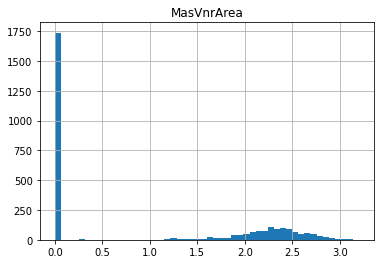

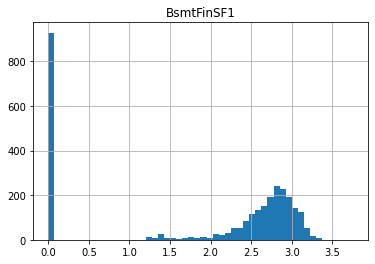

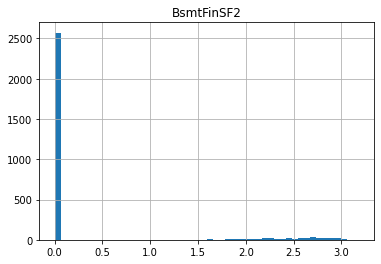

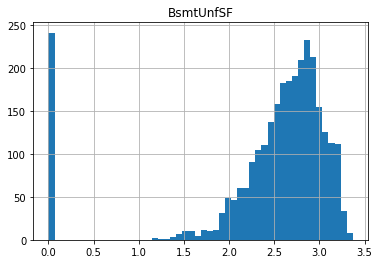

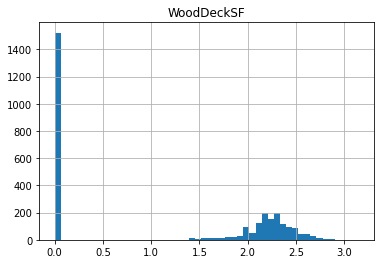

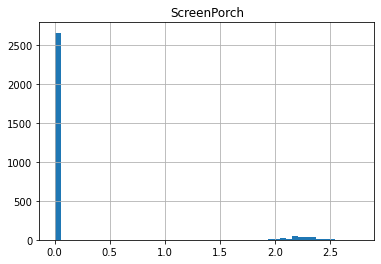

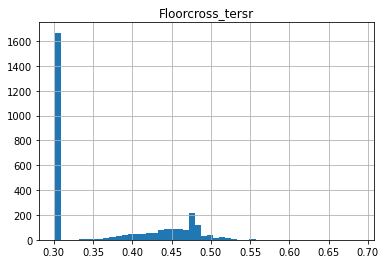

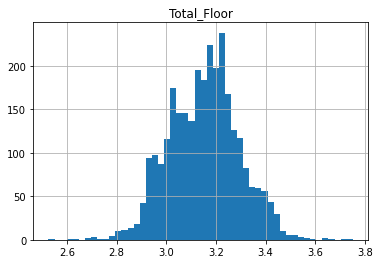

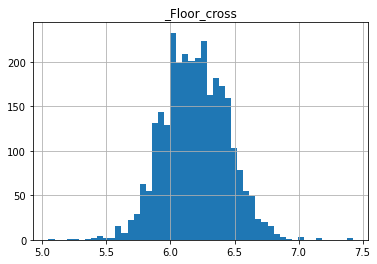

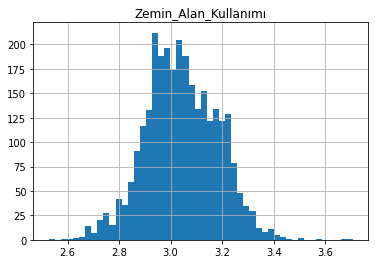

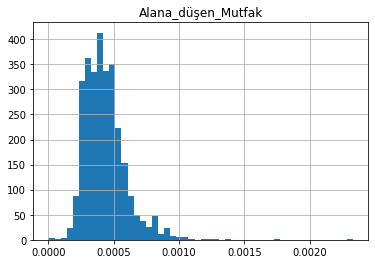

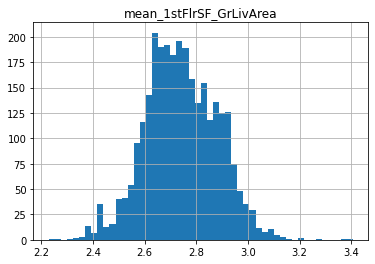

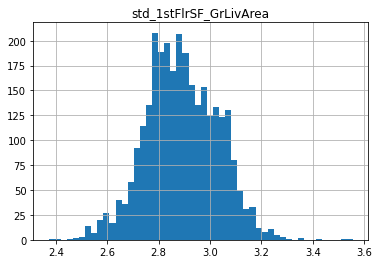

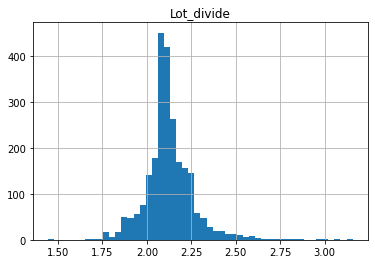

ValueError: supplied range of [-inf, 2.1367205671564067] is not finite

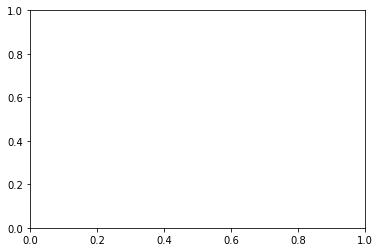

In [32]:
for col in num_cols:
    df.hist(col, bins=50)
    plt.show()

In [24]:
df["MSZoningLotFrontage_SUM"] = np.log10(df["MSZoningLotFrontage_SUM"] + 1)
df["MSZoningLotArea_MIN"] = np.log10(df['MSZoningLotArea_MIN'] + 1)
df["MSZoningLotArea_MEAN"] = np.log10(df['MSZoningLotArea_MEAN'] + 1)
df["MSZoningLotArea_SUM"] = np.log10(df['MSZoningLotArea_SUM'] + 1)
df["MSZoningLotArea_MAX"]  = np.log10(df['MSZoningLotArea_MAX'] + 1)
df["MSSubClassGarageArea_SUM"] = np.log10(df['MSSubClassGarageArea_SUM'] + 1)
df["MSSubClassGarageArea_MEAN"] = np.log10(df['MSSubClassGarageArea_MEAN'] + 1)
df["MSSubClassOpenPorchSF_SUM"] = np.log10(df['MSSubClassOpenPorchSF_SUM'] + 1)
df["MSSubClassTotalBsmtSF_SUM"]  = np.log10(df['MSSubClassTotalBsmtSF_SUM'] + 1)
df["MSSubClassTotalBsmtSF_MAX"] = np.log10(df['MSSubClassTotalBsmtSF_MAX'] + 1)
df["MSSubClass1stFlrSF_VAR"]  = np.log10(df['MSSubClass1stFlrSF_VAR'] + 1)
df["MSSubClass1stFlrSF_STD"] = np.log10(df['MSSubClass1stFlrSF_STD'] + 1)

In [25]:
df["MSSubClassRestore_age_VAR"] = np.log10(df['MSSubClassRestore_age_VAR'] + 1)

In [ ]:
na_list = [col for col in df.columns if df[col].isnull().sum() >0 and col not in "SalePrice"]
for col in na_list:
    df.dropna(subset=[col], how = "all", inplace=True)

In [74]:
def one_hot_encoder(df, drop_first=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, drop_first=drop_first)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

df, cat_colss = one_hot_encoder(df)

In [75]:
df.head()

,Id,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,WoodDeckSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,Floorcross_tersr,Total_Floor,_Floor_cross,Zemin_Alan_Kullanımı,Alana_düşen_Mutfak,bodrum_banyo_per,mean_1stFlrSF_GrLivArea,std_1stFlrSF_GrLivArea,Lot_divide,MSZoningLotFrontage_SUM,MSZoningLotFrontage_MEAN,MSZoningLotArea_MIN,MSZoningLotArea_MEAN,MSZoningLotArea_SUM,MSZoningLotArea_MAX,MSZoningLandSlope_NUNIQUE,MSZoningGrLivArea_STD,MSZoningGrLivArea_VAR,Home_Age,Restore_age,MSSubClassGarageArea_SUM,MSSubClassGarageArea_MEAN,MSSubClassOpenPorchSF_MIN,MSSubClassOpenPorchSF_MEAN,MSSubClassOpenPorchSF_SUM,MSSubClassOpenPorchSF_MAX,MSSubClassTotRmsAbvGrd_MEAN,MSSubClassTotRmsAbvGrd_SIZE,MSSubClassTotalBsmtSF_MEAN,MSSubClassTotalBsmtSF_SUM,MSSubClassTotalBsmtSF_MAX,MSSubClassGrLivArea_MIN,MSSubClassGrLivArea_MAX,MSSubClassGrLivArea_SIZE,MSSubClass1stFlrSF_VAR,MSSubClass1stFlrSF_MEAN,MSSubClass1stFlrSF_MAX,MSSubClass1stFlrSF_STD,MSSubClass2ndFlrSF_VAR,MSSubClass2ndFlrSF_STD,MSSubClass2ndFlrSF_MEAN,MSSubClass2ndFlrSF_MIN,MSSubClassEnclosedPorch_MIN,MSSubClassEnclosedPorch_MAX,MSSubClassHome_Age_MEAN,MSSubClassHome_Age_MAX,MSSubClassHome_Age_SUM,MSSubClassRestore_age_MEAN,MSSubClassRestore_age_VAR,MSSubClassRestore_age_MIN,MSSubClassRestore_age_MAX,MSSubClassRestore_age_SUM,MSSubClassTotal_Floor_MEAN,MSSubClassTotal_Floor_SUM,MSSubClassAlana_düşen_Mutfak_MEAN,MSSubClassAlana_düşen_Mutfak_SUM,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRR,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2T,BldgType_Duplex,BldgType_TwnhsE,HouseStyle_121,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SLvl,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_BB,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_OSC,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No_Basement,BsmtQual_TA,BsmtCond_Gd,BsmtCond_No_Basement,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtEx

In [77]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [78]:
X =train_df.drop(["SalePrice", "Id"], axis=1)

y = np.log1p(train_df['SalePrice'])

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [80]:
models = [("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.1489 (XGBoost) 
RMSE: 0.1351 (LightGBM) 
RMSE: 0.1269 (CatBoost) 


In [148]:
lgbm_model = LGBMRegressor(random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model,
                                        X, y, cv=5, scoring="neg_mean_squared_error")))


lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500, 2000, 5000],
               "max_bin":[255],
                'num_leaves': [7, 14, 21, 28, 31, 50],
               'max_depth': [-1, 3, 5],
               "colsample_bytree": [0.5, 0.7, 1]
             }

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


KeyboardInterrupt: 

In [38]:
final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

In [39]:
rmse

0.1172539903503339

In [197]:


catboost = CatBoostRegressor(**grid.best_params_,verbose=False)

rmse = np.mean(np.sqrt(-cross_val_score(catboost,
                                        X, y, cv=10, scoring="neg_mean_squared_error")))
rmse

0.11133198904768396

276:	learn: 0.0405509	total: 5.56s	remaining: 462ms
277:	learn: 0.0404442	total: 5.58s	remaining: 441ms
278:	learn: 0.0402727	total: 5.58s	remaining: 420ms
279:	learn: 0.0401899	total: 5.61s	remaining: 401ms
280:	learn: 0.0399961	total: 5.62s	remaining: 380ms
281:	learn: 0.0398776	total: 5.64s	remaining: 360ms
282:	learn: 0.0397773	total: 5.67s	remaining: 340ms
283:	learn: 0.0396289	total: 5.68s	remaining: 320ms
284:	learn: 0.0395296	total: 5.7s	remaining: 300ms
285:	learn: 0.0393566	total: 5.72s	remaining: 280ms
286:	learn: 0.0391196	total: 5.74s	remaining: 260ms
287:	learn: 0.0391074	total: 5.77s	remaining: 240ms
288:	learn: 0.0390980	total: 5.78s	remaining: 220ms
289:	learn: 0.0390871	total: 5.81s	remaining: 200ms
290:	learn: 0.0389040	total: 5.84s	remaining: 181ms
291:	learn: 0.0388471	total: 5.85s	remaining: 160ms
292:	learn: 0.0387088	total: 5.87s	remaining: 140ms
293:	learn: 0.0385610	total: 5.88s	remaining: 120ms
294:	learn: 0.0385529	total: 5.9s	remaining: 99.9ms
295:	learn: 0

In [222]:
def display_importances(X):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances01.png')

In [ ]:
final_catboost = CatBoostRegressor(**grid.best_params_, verbose=False).fit(X_train, y_train)
y_pred = final_catboost.predict(X_test)

In [ ]:

# Yapılan LOG dönüşümünün tersinin (inverse'nin) alınması
new_y= np.expm1(y_pred)

In [ ]:
np.sqrt(mean_squared_error(new_y_test, new_y))

In [ ]:
#lgbm_params = {"learning_rate": [0.01,0.02, 0.04, 0.05, 0.1],
               "n_estimators": [500, 1500,2000, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000]}
 
#lgbm_gs_best = GridSearchCV(lgbm_model,
                            #lgbm_params,
                           # cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

In [132]:

#final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

#rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
#rmse

In [ ]:
 The best score across ALL searched params:
 0.8803054783503172

 The best parameters across ALL searched params:
 {'max_depth': 4, 'n_estimators': 300}